In [6]:
import torch
import models.registry
import datasets.base, datasets.registry
from foundations import hparams
from pruning import fisher_pruning, sparse_global
import platforms.local
import numpy as np
import matplotlib.pyplot as plt

# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.size'] = 12
# plt.rcParams['axes.linewidth'] = 1.5
# plt.rcParams["figure.figsize"] = (9,6)

In [7]:
plat = platforms.local.Platform()
platforms.platform._PLATFORM = plat

In [8]:
hp = models.registry.get_default_hparams('mnist_lenet_300_100')
trained_model = models.registry.get(hp.model_hparams)
trained_model.load_state_dict(torch.load("../open_lth_data/lottery_2f4be23b7e4c30fb5fbf086d41cfacb7/replicate_1/level_0/main/model_ep50_it0.pth"))

<All keys matched successfully>

In [9]:
# Determine which layers can be pruned.
prunable_tensors = set(trained_model.prunable_layer_names)

# Get the model weights.
weights = {k: v.clone().cpu().detach().numpy()
           for k, v in trained_model.state_dict().items()
           if k in prunable_tensors}

In [10]:
# Obtain Fisher pruning mask
fisher_hparams = fisher_pruning.PruningHparams
fisher_hparams.num_data_points = 50000
fisher_mask = fisher_pruning.Strategy.prune(fisher_hparams, trained_model, None)

In [11]:
# Obtain mask by pruning smallest (absolute) weights
mag_hparams = sparse_global.PruningHparams
mag_mask = sparse_global.Strategy.prune(mag_hparams, trained_model, None)

In [12]:
fisher_pruned_weights = np.concatenate([weights[k][np.where(fisher_mask[k] == 0)].flatten() for k in fisher_mask.keys()])

In [13]:
mag_pruned_weights = np.concatenate([weights[k][np.where(mag_mask[k] == 0)].flatten() for k in mag_mask.keys()])

In [14]:
flattened_weights = np.concatenate([weights[k].flatten() for k in weights.keys()])

In [15]:
print(f"Max Fisher Pruning Absolute Weight: {np.max(fisher_pruned_weights)}")
print(f"Max Magnitude Pruning Absolute Weight: {np.max(mag_pruned_weights)}")
print(f"Max Weight in Network: {np.max(flattened_weights)}")

Max Fisher Pruning Absolute Weight: 0.6654332876205444
Max Magnitude Pruning Absolute Weight: 0.03552159294486046
Max Weight in Network: 1.181634545326233


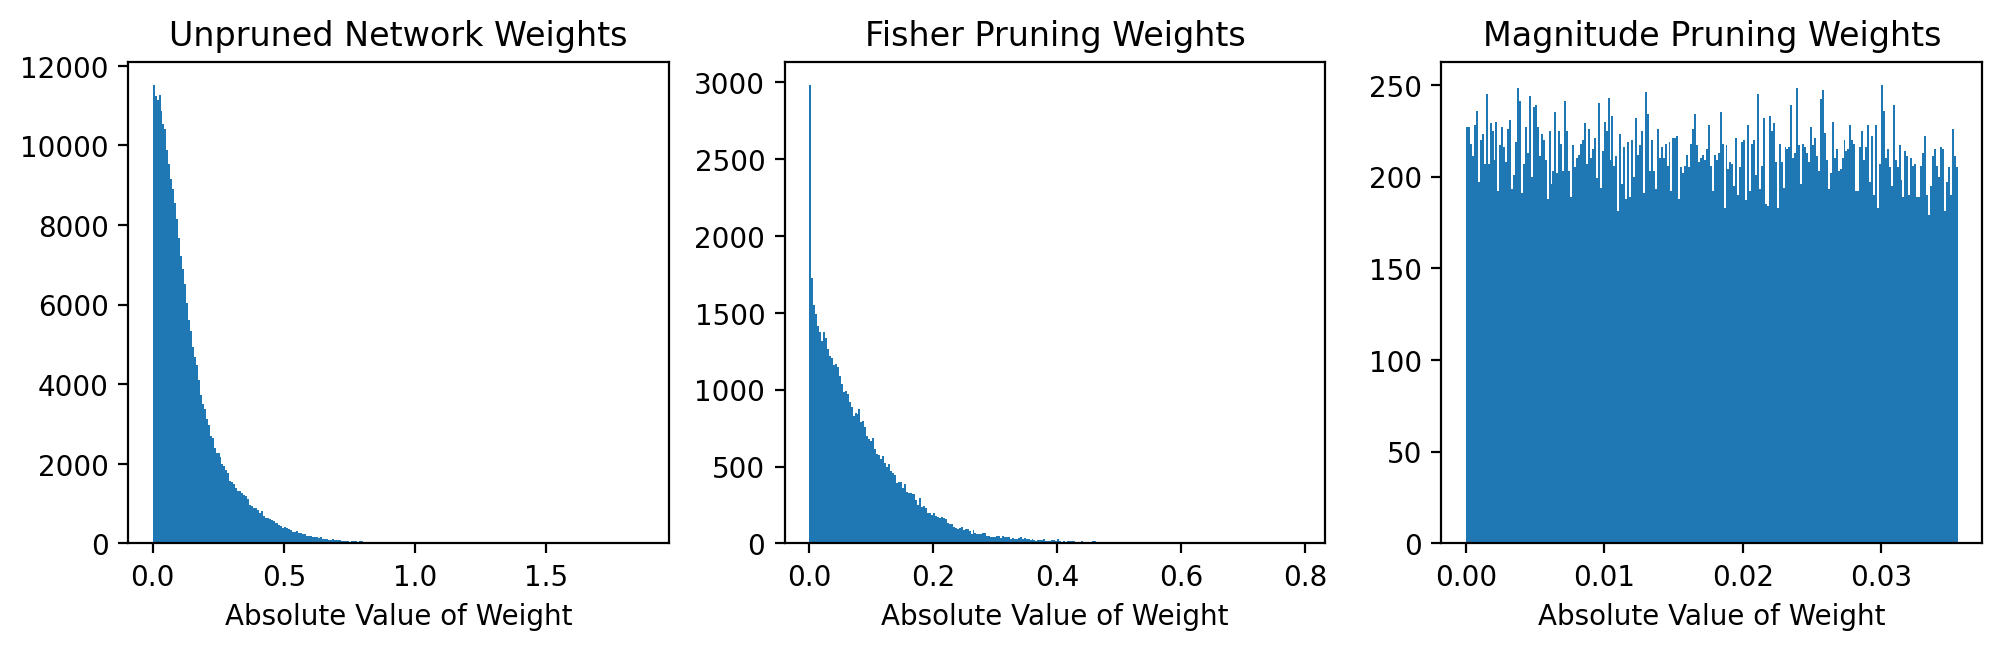

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3), dpi=200)
fig.tight_layout()
ax1.hist(np.abs(flattened_weights), bins=250)
ax1.set_title("Unpruned Network Weights")
ax1.set_xlabel("Absolute Value of Weight")
ax2.hist(np.abs(fisher_pruned_weights), bins=250)
ax2.set_title("Fisher Pruning Weights")
ax2.set_xlabel("Absolute Value of Weight")
ax3.hist(np.abs(mag_pruned_weights), bins=250)
ax3.set_title("Magnitude Pruning Weights")
ax3.set_xlabel("Absolute Value of Weight")
plt.savefig("plots/Pruned Weight Value Comparison.png", bbox_inches='tight')

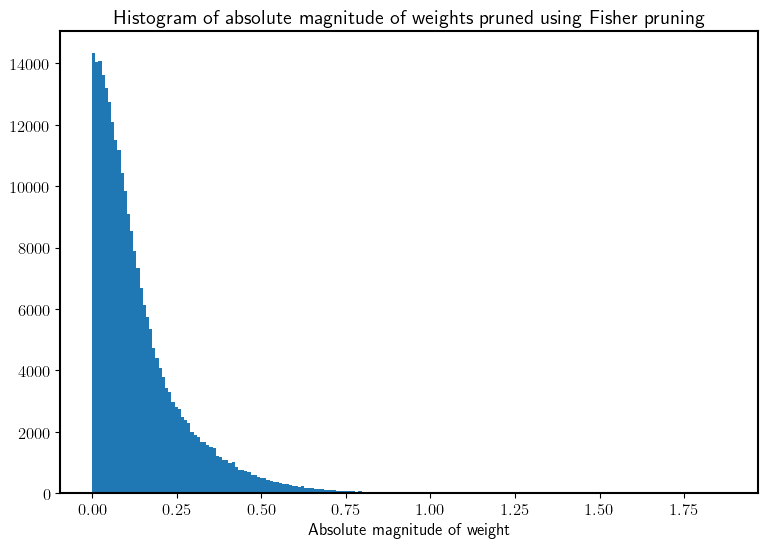

In [12]:
plt.hist(np.abs(flattened_weights), bins=200)
plt.title("Histogram of absolute magnitude of weights pruned using Fisher pruning")
plt.xlabel("Absolute magnitude of weight")
plt.show()

Max Weight: 0.7937043905258179


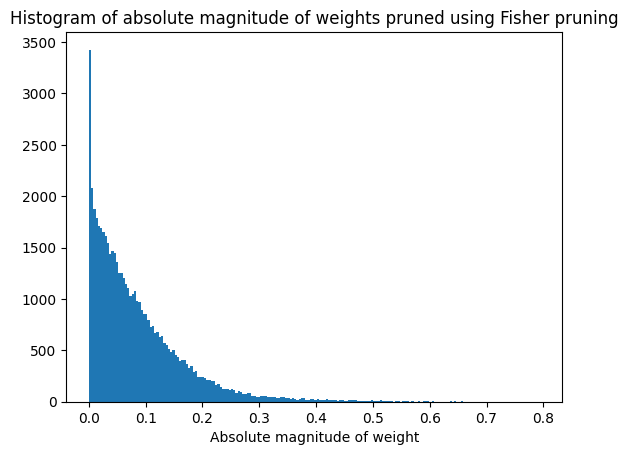

In [10]:
plt.hist(np.abs(fisher_pruned_weights), bins=200)
print(f"Max Weight: {np.max(np.abs(fisher_pruned_weights))}")
plt.title("Histogram of absolute magnitude of weights pruned using Fisher pruning")
plt.xlabel("Absolute magnitude of weight")
plt.show()

In [11]:
mag_pruned_weights = np.concatenate([weights[k][np.where(mag_mask[k] == 0)].flatten() for k in mag_mask.keys()])

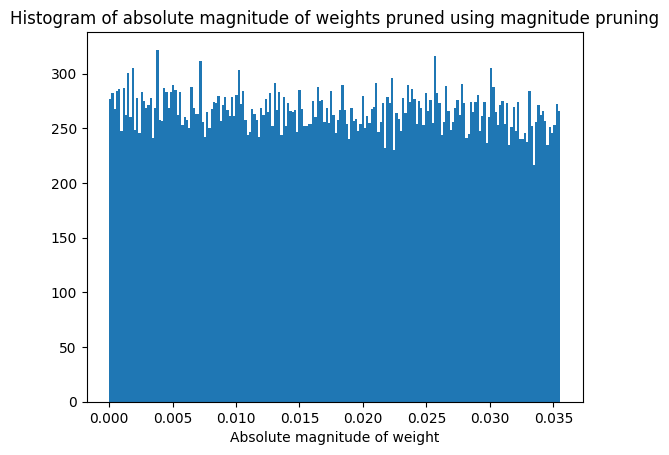

In [12]:
plt.hist(np.abs(mag_pruned_weights), bins=200)
plt.title("Histogram of absolute magnitude of weights pruned using magnitude pruning")
plt.xlabel("Absolute magnitude of weight")
plt.show()

In [12]:
dataset_hparams = hparams.DatasetHparams("mnist", 1)
dataloader = datasets.registry.get(dataset_hparams, train=False)

In [13]:
def fisher_delta_loss(trained_model: models.base.Model, dataloader: datasets.base.DataLoader, num_data_points: int):
    print(f"Number Data Points: {num_data_points}")

    # Determine which layers can be pruned.
    prunable_tensors = set(trained_model.prunable_layer_names)

    # Dictionary to store sum of squares of loss derivative w.r.t each parameter/training point
    squared_gradients_accumulator = {}
    for name in prunable_tensors:
        squared_gradients_accumulator[name] = np.zeros(list(trained_model.state_dict()[name].shape))

    # Loop over dataset, computing the square of the derivative of loss function w.r.t each prunable parameter
    dataloader_iterator = iter(dataloader)
    for _ in range(num_data_points):
        train_features, train_labels = next(dataloader_iterator)
        criterion = trained_model.loss_criterion
        loss = criterion(trained_model(train_features), train_labels)
        trained_model.zero_grad()
        loss.backward()
        # TODO: Double check detaching etc. doesn't cause any changes
        grad_dict = {k: v.grad.clone().cpu().detach().numpy() ** 2 for k, v in trained_model.named_parameters() if k in prunable_tensors}
        for k in grad_dict.keys():
            squared_gradients_accumulator[k] += grad_dict[k]

    # Get the square of the model weights
    weights_squared = {k: v.clone().cpu().detach().numpy() ** 2
                       for k, v in trained_model.state_dict().items()
                       if k in prunable_tensors}

    # Calculate approximate increase in loss corresponding to pruning each parameter individually
    delta_loss = {}
    for k in prunable_tensors:
        delta_loss[k] = (1 / (2 * num_data_points)) * np.multiply(weights_squared[k],
                                                                                  squared_gradients_accumulator[k])
    return delta_loss

In [14]:
fisher_delta_loss = fisher_delta_loss(trained_model, dataloader, num_data_points=len(dataloader.dataset))

Number Data Points: 10000


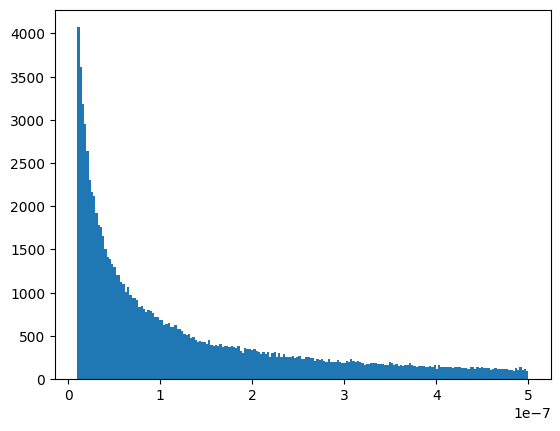

In [15]:
fisher_delta_loss_vector = np.concatenate([fisher_delta_loss[k].flatten() for k in prunable_tensors])
plt.hist(fisher_delta_loss_vector, range=[0.00000001, 0.0000005], bins=200)
plt.show()

In [16]:
weight_vector = np.concatenate([weights[k].flatten() for k in prunable_tensors])

In [17]:
bins = np.linspace(0, 1, 1000)
digitized = np.digitize(np.abs(weight_vector), bins)
bin_means = [fisher_delta_loss_vector[digitized == i].mean() for i in range(1, len(bins))]

/var/folders/pn/3853sf3j2mvg6k84ht938h_00000gn/T/ipykernel_67530/344746309.py:3: RuntimeWarning: Mean of empty slice.
  bin_means = [fisher_delta_loss_vector[digitized == i].mean() for i in range(1, len(bins))]
/Users/thomaschristie/Documents/GitHub.nosync/lth/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [18]:
pairs = np.stack((np.abs(weight_vector), fisher_delta_loss_vector), axis=-1)
pairs = pairs[np.argsort(pairs[:, 0])]

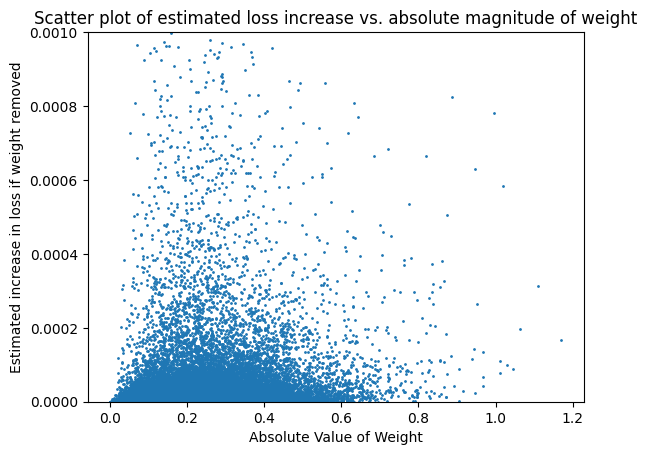

In [19]:
plt.scatter(pairs[:, 0], pairs[:, 1], s=1)
plt.ylim(0, 0.001)
plt.title("Scatter plot of estimated loss increase vs. absolute magnitude of weight")
plt.xlabel("Absolute Value of Weight")
plt.ylabel("Estimated increase in loss if weight removed")
plt.show()

In [20]:
num_correct = 0.0
num_samples = 0.0

with torch.no_grad():
    for input, label in dataloader:
            preds = np.argmax(trained_model(input), axis=1)
            num_correct += (preds == label).sum()
            num_samples += preds.size(0)

In [21]:
print(f"Validation Accuracy: {(num_correct/num_samples)*100}%")

Validation Accuracy: 97.43000030517578%
